<a href="https://colab.research.google.com/github/mlelarge/graph_neural_net/blob/main/plot_accuracy_regular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If running on Colab, uncomment the code below:
#!git clone https://github.com/mlelarge/graph_neural_net.git
#!pip3 install dgl
#%cd graph_neural_net

In [9]:
import os
from pathlib import Path
import math
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from models import get_model
from toolbox.losses import triplet_loss
from toolbox import metrics
from loaders.data_generator import QAP_Generator
from loaders.siamese_loaders import siamese_loader
from toolbox.metrics import all_losses_acc, accuracy_linear_assignment
from toolbox.utils import check_dir

In [35]:
def get_device_config(model_path):
    config_file = os.path.join(model_path,'config.json')
    with open(config_file) as json_file:
        config_model = json.load(json_file)
    use_cuda = not config_model['cpu'] and torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    return config_model, device

def load_model(model_path, config, device):
    model = get_model(config['arch'])
    model.to(device)
    model_file = os.path.join(model_path,'model_best.pth.tar')
    if device == 'cpu':
        checkpoint = torch.load(model_file,map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(model_file)
    model.load_state_dict(checkpoint['state_dict'])
    return model

def creat_args(config, num_ex = 1000):
    args = config['data']
    args['num_examples_test'] = num_ex
    n_vertices = args['n_vertices']
    edge_density = args['edge_density']
    deg = (n_vertices)*edge_density
    print(f'graphs with {n_vertices} vertices and average degree {deg}')
    return args, deg

def acc_2_error(mean_acc, q_acc):
    error = q_acc-mean_acc[:,np.newaxis]
    error[:,0] = -error[:,0]
    return error

def compute_all(list_noise,args,path_dataset,model,bs=50):
    num_batches = math.ceil(args['num_examples_test']/bs)
    all_losses = np.zeros((len(list_noise),num_batches))
    all_acc = np.zeros((len(list_noise),args['num_examples_test']))
    for i,noise in enumerate(list_noise):
        args['noise'] = noise
        gene_test = QAP_Generator('test', args, path_dataset)
        gene_test.load_dataset(use_dgl=False)
        test_loader = siamese_loader(gene_test, bs, gene_test.constant_n_vertices)
        all_losses[i,:], all_acc[i,:] = all_losses_acc(test_loader,model,criterion,device,eval_score=accuracy_linear_assignment)
    return all_losses, all_acc

def compute_quant(all_acc,quant_low=0.1,quant_up=0.9):
    mean_acc = np.mean(all_acc,1)
    num = len(mean_acc)
    q_acc = np.zeros((num,2))
    for i in range(num):
        q_acc[i,:] = np.quantile(all_acc[i,:],[quant_low, quant_up])
    return mean_acc, q_acc

# Downloading the pretrained model

The cell below should only be run once, it creates a folder `downloads/` and then downloads in this folder the pretrained model and the configuration file.

In [36]:
import requests
config_url = 'https://github.com/mlelarge/graph_neural_net/releases/download/QAP/config.json'
model_url = 'https://github.com/mlelarge/graph_neural_net/releases/download/QAP/model_best.pth.tar'
cwd = os.getcwd()
downloads = os.path.join(cwd, 'downloads')
check_dir(downloads)

r = requests.get(config_url)
with open(cwd+'/downloads/config.json', 'wb') as f:
    f.write(r.content)

r = requests.get(model_url)
with open(cwd+'/downloads/model_best.pth.tar', 'wb') as f:
    f.write(r.content)

In [37]:
model_path = cwd+'/downloads/'
config_model, device = get_device_config(model_path)

model = get_model(config_model['arch'])
model.to(device)
model_file = os.path.join(model_path, 'model_best.pth.tar')
if device == 'cpu':
	checkpoint = torch.load(model_file, map_location=torch.device('cpu'), weights_only=False)
else:
	checkpoint = torch.load(model_file, weights_only=False)
model.load_state_dict(checkpoint['state_dict'])

criterion = triplet_loss()

Fetching model Siamese_Model - Simple_Node_Embedding 


In [38]:
args,deg  = creat_args(config_model, num_ex=200)

graphs with 50 vertices and average degree 10.0


In [39]:
num = 8
list_noise = np.linspace(0, 0.22, num=num)

# Inference

The cell below will create dataset of graphs with various level of noise if they do not exist, otherwise it will only read them.

In [40]:
import importlib
import loaders.data_generator as data_generator
importlib.reload(data_generator)
from loaders.data_generator import QAP_Generator

from pathlib import Path
ROOT_DIR = Path.home()
path_dataset = os.path.join(ROOT_DIR, 'data/')
all_l, all_a = compute_all(list_noise, args, path_dataset, model)

Reading dataset at C:\Users\romai\data/QAP_Regular_ErdosRenyi_200_50_1.0_0.0_0.2\test.pkl
Reading dataset at C:\Users\romai\data/QAP_Regular_ErdosRenyi_200_50_1.0_0.03142857142857143_0.2\test.pkl
Reading dataset at C:\Users\romai\data/QAP_Regular_ErdosRenyi_200_50_1.0_0.06285714285714286_0.2\test.pkl
Reading dataset at C:\Users\romai\data/QAP_Regular_ErdosRenyi_200_50_1.0_0.09428571428571429_0.2\test.pkl
Reading dataset at C:\Users\romai\data/QAP_Regular_ErdosRenyi_200_50_1.0_0.12571428571428572_0.2\test.pkl
Reading dataset at C:\Users\romai\data/QAP_Regular_ErdosRenyi_200_50_1.0_0.15714285714285714_0.2\test.pkl
Reading dataset at C:\Users\romai\data/QAP_Regular_ErdosRenyi_200_50_1.0_0.18857142857142858_0.2\test.pkl
Reading dataset at C:\Users\romai\data/QAP_Regular_ErdosRenyi_200_50_1.0_0.22_0.2\test.pkl


# Results

The FGNN has been trained with regular graphs with $50$ vertices, average degree $10$ and noise level $0.15$. The accuracy below is the fraction of matched vertices between two noisy versions of a given graph at various level of noise.

In [45]:
quant_low=0.1
quant_up=0.9
mc_50, q50 = compute_quant(all_a,quant_low=quant_low,quant_up=quant_up)

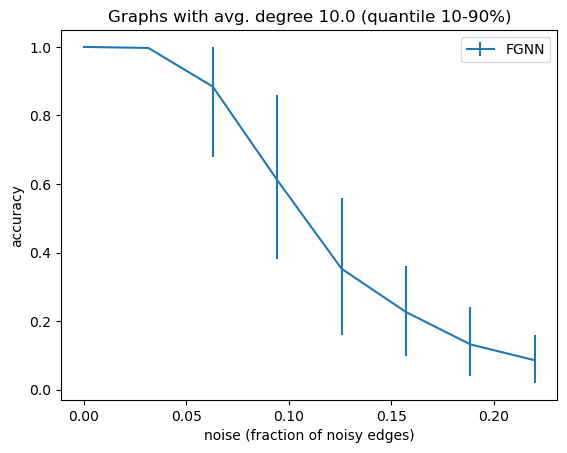

In [46]:
error_50 = acc_2_error(mc_50,q50)

# Robust non-negative error bars for matplotlib
lower_err = np.maximum(0.0, mc_50 - q50[:,0])
upper_err = np.maximum(0.0, q50[:,1] - mc_50)
yerr = np.vstack([lower_err, upper_err])

plt.errorbar(list_noise, mc_50, yerr=yerr, label='FGNN');
plt.xlabel('noise (fraction of noisy edges)')
plt.ylabel('accuracy')
plt.title(f'Graphs with avg. degree {deg} (quantile {int(100*quant_low)}-{int(100*quant_up)}%)')
plt.legend()
plt.show()